In [1]:
import pandas as pd

clinical = '/home/anton/Documents/Tulane/Hackathon/Clinical_fm_66_.csv'

df = pd.read_csv(clinical, sep=',')

print(df)

    rid  gp  1_age  1_sch_deg  1_yr_study  1_marital_st  1_occ  1_occ_t  \
0     2   0     50          1         6.0             2      5        0   
1     4   0     43          6        22.0             2      6        1   
2     5   0     40          3        16.0             3      5        0   
3     6   0     42          6        19.0             2      5        0   
4     7   1     43          6        25.0             2      1        1   
..  ...  ..    ...        ...         ...           ...    ...      ...   
61   73   1     37          6        20.0             1      1        3   
62   74   1     40          6        18.5             2      6        1   
63   75   1     45          5        15.5             2      1        3   
64   76   1     43          4        12.0             2      5        0   
65   77   1     42          5        16.0             1      2        1   

    1_m_inc  1_inc_dep  ...  15_9  15_10  15_11  16_int_task_ti  16_w  16_h  \
0      4000        1

In [23]:
# Fibromyalgia: 0=Yes, 1=No
# Fibromyalgia_Impact_Score: Non-fibro have N/A, set to 0

import numpy as np
import pickle

demo = dict()

fields = ['Fibromyalgia', 'Age', 'Pain_Score', 'Rheumatology_Score_1', 'Rheumatology_Score_2', 
          'Hamilton_Depression_Score', 'Hamilton_Anxiety_Score', 'Fibromyalgia_Impact_Score',
          'Weight', 'Height', 'BMI']

fields_csv_name = ['gp', '1_age', '1_vas_pain_iv', '3_sss_tc', '3_sss_ts', '6_hamd_total', '7_hama_total',
                  '12_sum', '16_w', '16_h', '16_bmi']

for f, fcn in zip(fields, fields_csv_name):
    demo[f] = dict()
    for i,row in df[['rid', fcn]].iterrows():
        val = row[fcn] if not np.isnan(row[fcn]) > 0 else 0
        if fcn == 'gp':
            demo[f][int(row['rid'])] = 'Yes' if val == 0 else 'No'
        else:
            demo[f][int(row['rid'])] = float(val)

folder = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/Fibromyalgia'
pickle.dump(demo, open(f'{folder}/demographics.pkl', 'wb'))

print('Complete')

Complete


In [61]:
from pathlib import Path
from scipy import signal
import re

from nilearn.connectome import ConnectivityMeasure

task = 'rest'
data = f'/home/anton/Documents/Tulane/Hackathon/ImageNomeR/data/fmri-ts-{task}'
kind = 'partial'

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 2
a,b = np.triu_indices(264,1)

pc_maker = ConnectivityMeasure(kind='partial correlation')

for f in Path(data).iterdir():
    ts = pickle.load(open(str(f), 'rb'))
    ts = butter_bandpass_filter(ts, [0.01, 0.15], 1/tr)
    match = re.match('sub-(\d+).pkl', f.name)
    sub = int(match.group(1))
#     p = np.corrcoef(ts) # Pearson correlation - FC
    p = pc_maker.fit_transform(np.expand_dims(ts.T, 0)) # Partial correlation - PC
    np.save(f'{folder}/{kind}/{sub}_task-{task}_{kind}.npy', p[0,a,b])
    
print('Done')

Done


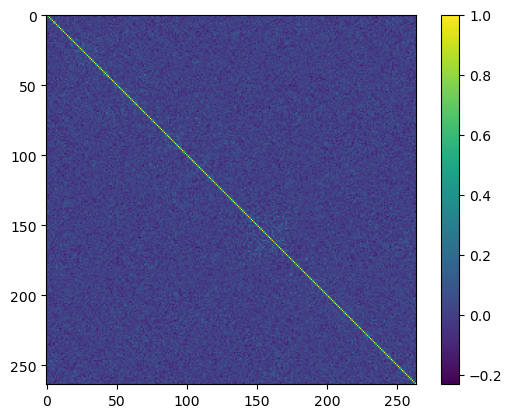

In [58]:
plt.imshow(p[0])
plt.colorbar()
plt.show()

In [79]:
# Making weights
# For display in ImageNomer

fibro_score = []
fc = []
subs = []

for sub, score in demo['Fibromyalgia_Impact_Score'].items():
    for task in ['rest', 'epr']:
        try:
            p = np.load(f'{folder}/fc/{sub}_task-{task}_fc.npy')
        except:
            continue
        fc.append(p)
        fibro_score.append(score)
        subs.append(sub)
        
fibro_score = np.array(fibro_score)
fc = np.stack(fc)

print([a.shape for a in [fc, fibro_score]])

[(131, 34716), (131,)]


In [84]:
# Continue making weights

# Weights are dictionaries that contain at least the following fields:
# w (numpy.ndarray 1D flattened like FC)
# trsubs (list(str))
# tsubs (list(str))
# desc (str)

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split

what = 'Lasso'

def rmse(yhat, y):
    return np.mean((yhat-y)**2)**0.5

def make_dict(w, trsubs, tsubs, err, nullerr):
    desc = f'{what} alpha=1 predict Fibromyalgia_Impact_Score err={err} nullerr={nullerr}'
    return dict(w=w, trsubs=trsubs, tsubs=tsubs, desc=desc)

def save_run(i, dct):
    pickle.dump(dct, open(f'{folder}/weights/Fibromyalgia_Impact_Score/{what}{i}.pkl', 'wb'))

for i in range(3):
    xtr, xt, trsubs, tsubs, ytr, yt = train_test_split(fc, subs, fibro_score, train_size=0.9)

    reg = Lasso(alpha=1).fit(xtr, ytr)
    yhat = reg.predict(xt)
    err = rmse(yhat, yt)
    nullerr = rmse(np.mean(ytr), yt)

    dct = make_dict(reg.coef_.squeeze(), trsubs, tsubs, err, nullerr)
    save_run(i, dct)